In [1]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Video, Image, HTML
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import gzip
import pickle
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (9, 6)
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0
from celluloid import Camera

##### Time series, auto-regressive models

### David Picard 
### École Nationale des Ponts et Chaussées
### david.picard@enpc.fr

> _Prediction is difficult, especially if it's about the future_, 

Niels Bohr

- Specific case of $y=f(x)$ where $y$ are $x$ are temporally related
- Often used in a setup that breaks classical ML assumption (i.i.d., stationarity)


# General setup

- Stochastic process $X_t, 0 \leq t \leq T$
- Observe $\{X_t\}_{1\leq t \leq \tau}$ for $\tau < T$
- Predict $\{X_t\}_{\tau < t \leq T}$

Simplest case: predict next value $X_T$ from $X_{t<T}$

## Training set

Machine Learning relies on i.i.d. training/test data, but

- Obviously $P(X_T | X_{t<T}) \neq P(X_T)$ else nothing to observe
- Training set has to consist of _many_ independant sequences (i.d.), else no generalization

Typical cases:

- $X_t = f(X_{t-1}, ..., X_0)$ autoregressive process
- $X_t = f(X_{t-1})$, Markov process
- $Y_t = f(X_{t}), X_t = g(X_{t-1})$, Hidden Markov model (observe $Y$, deduce $X$)
- $Y_t = f(X_t, ..., X_0, Y_{t-1}, ..., Y_0)$, Infinite impulse response system (control theory)

# Autoregressive processes

Setup:

$$ X_n = f(X_{n-1}, ... X_0) $$

Assume linear model with additive noise:

$$ X_n = \sum_{k=1}^P a_k X_{n-k} + \epsilon_n, \epsilon_n \sim \mathcal{N}(0, \sigma_\epsilon) $$

Assume stationarity:

- $\forall n, E[X_n] = E[X_0] = \mu$, constant mean (=0 for simplicity)
- $\forall n, k, E[X_n X_k] = E[X_{n-k}X_0]$, autocorrelation does not depend on $t$, only $n-k$
- $\forall n, E[X_n^2] < \infty$, bounded variance

Then, one long sequence split into chunks is as good as many small sequences

## Fitting the model

Multiplying by $X_{n-m}$ and taking the expectation:

$$ \gamma_X(m) = \sum_{k=1}^P a_k \gamma_X(m-k) + \gamma_{X,\epsilon}(k) $$

with $\gamma_X(k) = E[X_n X_{n-k}]$ the autocorrelation and $\gamma_{X,\epsilon}(k)=E[X_n \epsilon_{n-k}]$ the cross-correlation

Note that $\gamma_{X,\epsilon}(k) = 0$ except for $\gamma_{X,\epsilon}(0) = \sigma_\epsilon^2$ ($\epsilon_t$ are independant)

We have a system of $P+1$ equations (called Yule-Walker equations):

$$ \gamma_X(0) = \sum_{k=1}^P a_k \gamma_X(k) + \sigma_\epsilon^2 \\
\gamma_X(m) = \sum_{k=1}^P a_k \gamma_X(m-k)$$

In matrix form:
$$ \Gamma_X \mathbf{a} = \mathbf{p}\quad\quad\quad\quad\\
\gamma_X(0) = \mathbf{a}^\top\gamma_X + \sigma_\epsilon^2$$

with $\Gamma_X$ the covariance matrix (symmetric, $\geq 0$)

Which corresponds to a least square problem.

Solution:

$$ \mathbf{a} = \Gamma_X^{-1}\mathbf{p} \quad\quad\quad\quad\quad\\
\sigma_\epsilon = \gamma_X(0) - \mathbf{p}^\top\Gamma_X^{-1}\mathbf{p}$$

- $\mathbf{a}$ corresponds to frequencies associated with a linear filter
- Start from pure noise $\rightarrow$ get a process that resembles the observations
- $n$-step ahead prediction: use $X_{\leq n}$ to predict $X_{n+1}$, then add to the sequence and predict $X_{n+2}$
- AR models can be used online: the more you observe, the more you can refine the future
- Limited to stationary processes (rare for interesting problems)
- For generic processes $X$, AR modeling is the best linear model in least square, and $\sigma_\epsilon$ is the error in modeling

## Example

Trying with the periodique function from the chapter on Linear Models.

In [2]:
a = np.array([0.7, 0.83, -1.5])
x = np.linspace(-10, 5, 75)
X = np.array([ np.sin(x), np.sin(2*x), np.sin(3*x)])
y = np.matmul(a, X) + 0.1*np.random.randn(75)

In [3]:
def fit_ar_p(y, P):
    N = len(y)-P-1
    T = np.array([y[i:i+P+1] for i in range(N)]) # set of P sized sequences
    T = T.T @ T / N # covariance matrix
    G = T[0:P, 0:P]
    p = T[P,0:P]
    a_hat = np.linalg.inv(G)@p.T
    s_hat = T[P,P] - p@np.linalg.inv(G)@p.T
    return a_hat, s_hat

In [4]:
P = 1
a_hat, s_hat = fit_ar_p(y, P)

In [5]:
# AR prediction
y_hat = y[-P:]
for i in range(25):
    next = np.array([np.dot(y_hat[-P:], a_hat) + s_hat*np.random.randn()])
    y_hat = np.concatenate([y_hat, next])

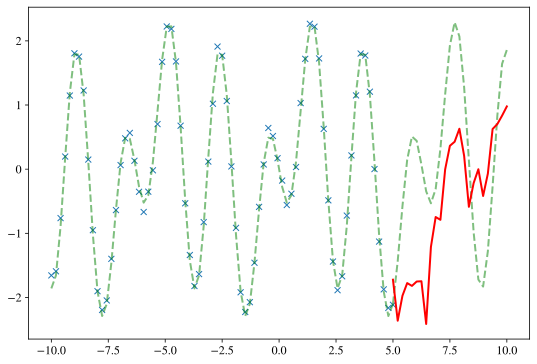

In [6]:
x2 = np.linspace(5, 10, 25)
plt.plot(x, y, 'x')
plt.plot(x, np.matmul(a, X), 'g--', alpha=0.5)
plt.plot(x2, np.matmul(a, np.array([ np.sin(x2), np.sin(2*x2), np.sin(3*x2)])), 'g--', alpha=0.5)
plt.plot(x2, y_hat[P:], 'r-')

In [7]:
P = 10
a_hat, s_hat = fit_ar_p(y, P)

In [8]:
# AR prediction
y_hat = y[-P:]
for i in range(25):
    next = np.array([np.dot(y_hat[-P:], a_hat) + s_hat*np.random.randn()])
    y_hat = np.concatenate([y_hat, next])

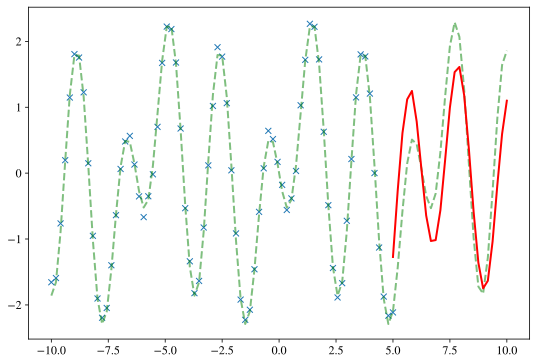

In [9]:
x2 = np.linspace(5, 10, 25)
plt.plot(x, y, 'x')
plt.plot(x, np.matmul(a, X), 'g--', alpha=0.5)
plt.plot(x2, np.matmul(a, np.array([ np.sin(x2), np.sin(2*x2), np.sin(3*x2)])), 'g--', alpha=0.5)
plt.plot(x2, y_hat[P:], 'r-')

In [10]:
P = 25
a_hat, s_hat = fit_ar_p(y, P)

In [11]:
# AR prediction
y_hat = y[-P:]
for i in range(25):
    next = np.array([np.dot(y_hat[-P:], a_hat) + s_hat*np.random.randn()])
    y_hat = np.concatenate([y_hat, next])

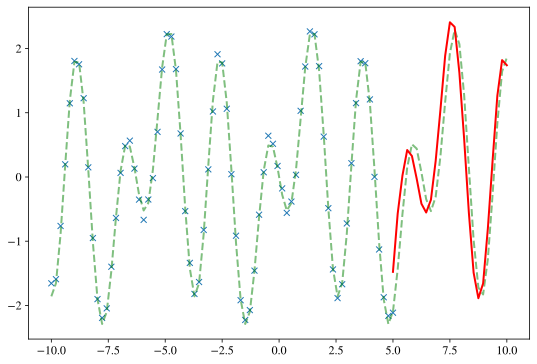

In [12]:
x2 = np.linspace(5, 10, 25)
plt.plot(x, y, 'x')
plt.plot(x, np.matmul(a, X), 'g--', alpha=0.5)
plt.plot(x2, np.matmul(a, np.array([ np.sin(x2), np.sin(2*x2), np.sin(3*x2)])), 'g--', alpha=0.5)
plt.plot(x2, y_hat[P:], 'r-')

# Markov Models

## Markov chains

Consider discrete process $X_n \in \mathcal{C}, \vert\mathcal{C}\vert = M$ states

- Markov property: $P(X_n | X_{n-1}, ..., X_0) =  P(X_n|X_{n-1})$
- Limited memory equivalence:

$$P(X_n | X_{n-1}, ... X_0) =  P(X_n|X_{n-1}, ..., X_{n-l}) \Leftrightarrow P(Y_n|Y_{n-1}, ..., Y_0) = P(Y_{n}|Y_{n-1}), Y_n = X_n...X_{n-k}$$

Use the observations to estimate the transition matrix:

$$ \mathbf{P} =  [P(X_n = j | X_{n-1} = i)]_{i,j} $$

- Empirical estimation
- Each row is $\geq0$ and sums to 1 (row stochastic matrix)
- Given a state distribution $\pi$, the next state distribution is given by $\pi \mathbf{P}$

Stationary distribution $\pi$ given by

$$ \pi = \pi \mathbf{P}$$

- Corresponds to iterating the process, $\mathbf{P}^k, k\rightarrow \infty$
- $\pi$ is a left eigenvector of $\mathbf{P}$
- Convergence in $\lambda_1/\lambda_2$ (iterated power of $\mathbf{P}$
- See Perron-Frobenius theorem for nice properties of such processes

## Hidden Markov models

What if $X$ is not observable, but $Y$ is?

- Model $P(Y_n | X_n)$ (emission probability)
- Model $P(X_n | X_{n-1})$ (transition probability)

$Y_n$ can be either discrete or continous.

See the good (but old) tutorial by <cite data-cite="rabiner89hmm">(Rabiner, 1989)</cite>

### Three problems

Consider HMM model $\lambda(A, B, \pi)$ with transition matrix $A$, emission vector $B$ and initial distribution $\pi$

1. Given $Y_0, ..., Y_n$, how to efficiently compute $P(Y|\lambda)$? (observation probability of $Y$)
2. Given $Y_0, ..., Y_n$, how to estimate the best $X_0, ..., X_n$ in the sense of $\lambda$? (explication for $Y$)
3. Given $Y_0, ..., Y_n$, how to adjust $\lambda$ to maximize the lieklihood of $Y$? (learning the HMM)

### Probability estimation

Probability of an observed sequence $Y = Y_0, ..., Y_n$:

- $P(Y) = \sum_X P(Y|X)P(X)$
- sum over all possible hidden state sequences $X = X_0, ..., X_n$ 

Done using dynamic programming

Forward Algorithm:

$$\alpha(X_t) = P(Y_{\leq t}, X_t)$$

Using the chain rule, following recusrion:

$$\alpha(X_t) = P(Y_t|X_t)\sum_{X_{t-1}} P(X_t|X_{t-1}) \alpha(X_{t-1}) $$

- $P(Y_t|X_t) = B_{Y_t}$ the corresponding row of the emission matrix $B$
- $P(X_t|X_{t-1})$ the corresponding cell of the transition matrix $A$
- Initialize with $\alpha(X_0)$ from $P(X_0)$

### Best hidden states explanation

Viterbi algorithm  <cite data-cite="viterbi67">(Viterbi, 1967)</cite>

- Forward pass: compute the state that has max probability given past
- Backward pass: starting from the maximum proba last state, iterate previous

Complexity in $T \times M^2$

## Fitting HMM

Expectation Maximization (Baum-Welsh algorithm  <cite data-cite="baum70maximization">(Baum, 1970)</cite>):

- Estimate probabilities of $X$ and $Y$ given model
- Update transition and emission matrices according to maximize the estimated probabilities

Estimation

- Forward/backward variables:

$$ \alpha_i(t) = P(Y_{\leq t}, X_t=i) =  \sum_{j}\alpha_j(t-1)a_{j,i} b_i$$
$$ \beta_i(t) = P(Y_{>t}, X_t = i) = \sum_j \beta_j(t+1)a_{i,j} b_j$$

- Intermediate variables:

$$ \mathcal{L} = P(Y) = \sum_i \alpha_i(T) $$
$$ \gamma_i(t) = P(X_t = i | Y_{\leq t}) = \frac{\alpha_i(t)\beta_i(t)}{\mathcal{L}}$$
$$ \xi_{i,j}(t) = P(X_t=i, X_{t+1}=j | Y_{>t}) = \frac{\alpha_i(t)a_{i,j}b_j \beta_j(t+1)}{\mathcal{L}}$$

Maximization

$$\pi = \gamma(1)$$
$$a_{i,j} = \frac{\sum_t \xi_{i,j}(t)}{\sum_t \gamma_i(t)}$$
$$b_i = \frac{\sum_t [\gamma_i(t)]_{=Y_t}}{\sum_t \gamma_i(t)}$$

# Gaussian Processes

Distribution over functions defined by the Gaussian distribution

- Set of observation $X = \{X_0, ..., X_n\}$
- Random function $f$ sampled from a distribution such that

$$ f(X) = \mathcal{N}(m(X), k(X,X)) $$

with $m(X)$ a function providing the means for $X$ and $k(X,X)$ providing the covariances for $X$

## Choice of kernel

- $k(x,x')$ has to be positive definite (to lead to a feasible covariance matrix)
- Models how different points influence each other

Popular choice: Gaussian kernel

$$ k(x_1, x_2) = \exp\left( \frac{\|x_1 - x_2\|^2}{2\sigma^2} \right) $$

with $\sigma$ carefully chosen

## Inference 

Predict $Y_2 = f(X_2)$ depending on observed data $X_1, Y_1$

Assume that $Y_1$ and $Y_2$ come from the same multivariate Gaussian:

$$ \begin{bmatrix}Y_1 \\ Y_2 \end{bmatrix} = \mathcal{N}\left(\begin{bmatrix}\mu_1 \\ \mu_2\end{bmatrix}, \begin{bmatrix}\Sigma_{11}, \Sigma_{12}\\ \Sigma_{21}, \Sigma_{22} \end{bmatrix} \right)$$

With $\Sigma_{ij} = k(X_i, X_j)$

Getting the conditional probability

$$P(Y_2 | Y_1, X_1, X_2) = \mathcal{N}(\mu_{2|1}, \Sigma_{2|1})$$

with 
$$\mu_{2|1} = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1}(Y_1 - \mu_1) = \Sigma_{21} \Sigma_{11}^{-1}(Y_1 - \mu_1)$$
(assume $\mu_2 = 0$)
$$\Sigma_{2|1} = \Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12} $$

## Handling noise

$$ f(X2) = Y_2 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma) $$

Model in the kernel:

$$ \Sigma_{11} = k(X,X) + \sigma I $$

## Example

Trying with the periodique function from the chapter on Linear Models.

In [13]:
a = np.array([0.7, 0.83, -1.5])
x = np.random.rand(48)*16-8
X = jnp.array([ jnp.sin(x), jnp.sin(2*x), jnp.sin(3*x)])
y = jnp.matmul(a, X) + 0.2*np.random.randn(48)

In [14]:
def GaussKernel(x1, x2, gamma=5):
    x1 = jnp.expand_dims(x1, 1)
    x2 = jnp.expand_dims(x2, 1)
    return jnp.exp(-gamma*( jnp.linalg.norm(x1, axis=-1, keepdims=True)**2 + jnp.linalg.norm(x2, axis=-1, keepdims=True).T**2 - 2*jnp.dot(x1, x2.T)))

In [15]:
def sample_gp(X2, X1, Y1, kernel, noise=0.25):
    S11 = kernel(X1, X1) + noise * jnp.eye(len(X1))
    S22 = kernel(X2, X2)
    S12 = kernel(X1, X2)
    S21 = S12.T

    mu1 = jnp.mean(X1)
    S11inv = jnp.linalg.inv(S11)

    mu2to1 = S21 @ S11inv @ (Y1 - mu1)
    S2to1 = S22 - S21 @ S11inv @ S12

    return mu2to1, jnp.diag(S2to1) # mean = best prediction, var = range of functions

In [16]:
x2 = np.linspace(-10, 10, 200)
X2 = np.array([np.sin(x2), np.sin(2*x2), np.sin(3*x2)])
y2, s2 = sample_gp(x2, x, y, GaussKernel)

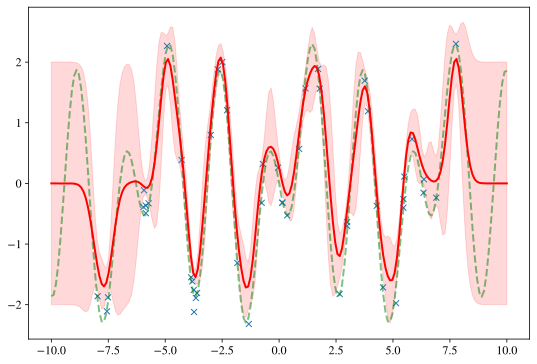

In [17]:
plt.plot(x, y, 'x')
plt.plot(x2, np.matmul(a, X2), 'g--', alpha=0.5)
plt.plot(x2, y2, 'r-')
plt.fill_between(x2, y2-2*s2, y2+2*s2, color='red', alpha=0.15)
plt.show()

## Exercice

Try to fit the previous example using periodic kernels

$$ k(x_1, x_2) = \exp\left( - \gamma \sin^2 \left(\frac{\|x_1 - x_2 \|}{p}\pi\right)\right)$$

# Recurrent neural networks

Use a neural network to model the transition from $X_n$ to $X_{n+1}$

$$ X_{n+1} = f_\theta(X_n) $$

In practice, keep information in a hidden state:

$$ X_{n+1}, H_{n+1} = f_\theta(X_n, H_n) $$

With $H_n$ hidden state (initialized to 0)

## Training an RNN

- Offset the observed sequence:
$$Y_0, ..., Y_n = X_1, ..., X_{n+1}$$

- Unroll the forward pass:
$$f_\theta(X_0, 0), ..., f_\theta(X_n, H_n)$$

- SGD with teacher forcing:
$$\min_\theta \sum_i \|Y_i - f_\theta(X_i, H_i)\|^2$$

- Sequential cost during training, costly for very long sequences
- Inference is almost always out-of-distribution

### Vanishing information

Linear model:

$$H_{n+1} = f(X_n, H_n) = W_h H_n + W_x X_n$$

Full unrolling:

$$H_{n+1} = W_h^n W_x X_0 + g(X_1, ..., X_n) $$

Depending on the spectrum of $W_h$, $X_0$ could have totally vanished from $H$

## LSTM

Preventing vanishing information  <cite data-cite="hochreiter1997long">(Hochreiter, 1997)</cite>

- Hidden state can store finite amount of information
- Decide when to let information in
- Decide when to forget information

- input gate: $i_n = \sigma_g(W_{i,x} x_n + W_{h,x} h_n)$
- forget gate: $f_n = \sigma_g(W_{f,x} x_n + W_{h,x} h_n)$

- cell input: $\tilde{c}_n = \sigma_h(X_{c,x} x_n + W_{c,h} h_n)$
- cell: $c_n = f_n \odot c_{n-1} + i_n \odot \tilde{c}_n$

- output gate: $o_n = \sigma_g(W_{o,x} x_n + W_{o,h} h_n)$
- output: $h_n = o_n \odot \sigma_h(c_n)$

$\sigma_g$ sigmoid, $\sigma_h$ hyperbolic tangent

Prediction:

- Stack several layers (for layer $L$, forward hidden state such that $X_n^L = H_n^{L-1}$)
- Transform last layer hidden state $H_n$ into the next input $X_{n+1}$


LSTM are notoriously hard to train

- Sigmoids saturate $\rightarrow$ carefull initialization and learning rate
- Need unrolling and sequential processing during training
- Causal problem: need to guess what to put in the cell before knowing if it's useful

# Autoregressive transformers

RNN have 2 problems:

- Sequential training is slow and costly
- Inference is tricky (need to memorize patterns before knowing if it's useful)

Transformers solve both problem:

- Training can be done in parallel
- Memorizes all the input sequence

### (Softmax) Attention

- Input sequence $X$ (sequence of tokens in columns)
- Projection $W_q, W_k, W_v$

Queries, Keys, Values:

$$ Q = W_q X, K = W_k X, V = W_v X$$

Attention matrix (Gram matrix + softmax):

$$ A = \sigma(Q^\top K) $$

Attention operation:

$$ Y = X + AV $$

Aggregates information from the sequence into each token

### Transformer layer

Residual attention and small MLP (typically 1 hidden layer)

$$ X^{L+1} = X^L + \sigma(Q^\top K)V + \text{FFW}(X) $$

- Attention: mixes information between tokens
- MLP: processes each token

### Masked attention

Transorfmers are intented for set (permutation equivariant) $\rightarrow$ masked attention

- Causal sequence: token $X_t$ can only attend tokens $X_{\leq t}$
- Mask: binary, lower triangular matrix $M$

$$ A = \sigma(Q^\top K) \odot M^\top $$

### Universal approximation theorem

Transformers are universal sequence to sequence approximator <cite data-cite="yun20transformerunivapprox">(Yun, 2020)</cite>

Define the distance $d_p$ as:
$$
    d_p(f, g) = \left(\int \| f(X) - g(X)\|_p^pdX\right)^{1/p}
$$

Theorem: Let $1 \leq p \leq \infty$ and $\epsilon > 0$, then for any given $f\in \mathcal{F}$ the set of continuous functions that map a compact domain in $\mathbb{R}^{d\times n}$ to $\mathbb{R}^{d\times n}$, there exists a Polymorpher $g$ with learned positional encoding such that $d_p(f, g) \leq \epsilon$.

Proof: Attention can map sequences to unique value, MLP can map unique input values to unique outputs.


### Quadratic cost

Computing attention is $\mathcal{O}(n^2)$ with sequence length $n$



Fast approximation:

- Low rank approx: LinFormer <cite data-cite="wang2020linformer">(Wang, 2020)</cite>
- Hashing or nearest neighbor based: <cite data-cite="kitaev20reformer">(Kitaev, 2020)</cite>
- Quadratic approx with closed form linearization: PoM <cite data-cite="picard24pom">(Picard, 2024)</cite>

# Time series, take home

AR:

- Linear model
- Online update
- Stationarity hypothesis

HMM:

- Models transition and emission probability
- Easier in discrete case (categorical distributions)
- Fitting the model is complex


RNN:

- Non-linear model (high capacity)
- Teacher forcing for training (OOD)
- Vanishing information

LSTM:

- Decision to add or remove from the hidden state
- Difficult to train
- Causality pb (decide what to keep before it is useful)

Transformers:

- State of the art for long term dependencies (eg, LLM)
- Memorizes all the past
- Attention cost quadratic $\rightarrow$ fast approximation (Linformer, Reformer, PoM, etc)